<h1><img align="right" width="350" src="img/ATU-Logo-Full-RGB-Green.jpg"> Programming for Data Analysis - Project 1
</h1>
<p> 
Course: HDip in Computing in Data Analytics <br>
Module: Programming for Data Analysis <br>
Lecturer: Brian McGinley <br>
Project: Project 1 for the Programming for Data Analysis module of the HDip in Data Analytics beginning January 2023. 
    
Student: Eilis Donohue (G00006088)

Project spec:
The project specification states that a real world dataset should be used (HOLD)

Software Used: 
 - Python v3.10 and higher
 - Jupyter Notebook 6.5.2   
 </p>

## Table of Contents
- [Introduction](#Intro)
- [Dataset Ingest and Preparation](#Prep)
- [Preliminary Analysis](#Prelim)
- [Overall Variable Correlation](#Corr)
- [Rainfall Analysis](#Rain)
- [Pressure Analysis](#Pressure)

## Introduction <a id="Intro"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

The historical meteorological data from the weather station at Athenry, Co. Galway has been downloaded for **8 years (data goes back to 2010)** from the met.ie website [1]. This dataset comprises a number of meteological variables as previewed below. The raw dataset (hly1875.csv) is stored in the \data folder. For the purposes of this study, the following variables have been chosen for analysis and data synthesisation.

- Rainfall
- Air Temperature
- Mean sealevel pressure
- Mean Wind speed

Each row of the raw dataset is an hourly recording of each variable.  This study is summarised as follows:

1. A preliminary analysis of the dataset (4 variables above) is performed to gain some insight into the overall trends and data distribution.
2. To simplify the data and its synthesisation, a daily aggregation of the variables is performed based on mean (and daily summation in the case of rainfall).
3. As weather is seasonal, a season variable is assigned to the data to allow for potentially more accurate distribution fitting and data synthesisation.
4. Each of the four variables above is analysed and a distribution is fitted based on curve fitting to the real data histograms. **Scipy stats** is used to generate fitted distributions and choose the most appropriate distribution for each dataset.
5. Data is synthesised using appropriate **Numpy** random number generators models using the distribution features found in step 4. 

## Date Ingest and Preparation  <a id="Prep"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span>

This section has the code used to ingest the data csv file and do some preparation of the data (i.e., convert the numeric fields to floats and remove blankspaces). The following steps are taken to prepare the data:

1. The data is read in to a **Pandas** dataframe.
2. The 4 variables of interest are isolated and copied to another dataframe.
3. The timestamp in the dataset is converted to a datetime object. The data is indexed by datetime as appropriate.  
4. Weather is inherently seasonal, so a new variable season is added to the dataframe based on the month (i.e., meteorological winter is December to February inclusive, and so on).
5. The data is reduced to a daily aggregation based on the daily mean or sum (in the case of rainfall).

In [40]:
# Import the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, rayleigh, lognorm, multivariate_normal, expon

from scipy.optimize import *
import numpy as np
import math

In [2]:
# Some function definitions
# Returns a season designation based on month to a dataframe 
def split_seasons(df_to_split, months):
  season_df = pd.DataFrame()
  for month in months:
    month_loc = df_to_split['datetime'].dt.month.between(month, month)
    season_df = pd.concat([season_df, df_to_split.loc[month_loc]])
  return season_df

# Returns Pearsons correlation on dataframe
def get_corr(data):
    return data.corr()

# assigns a season class to the data to allow for referencing of data without splitting dataframe
def assign_season_class(the_data, the_class, months):
  for month in months:
    month_loc = the_data['datetime'].dt.month.between(month, month)
    the_data.loc[month_loc, 'season'] = the_class
  return the_data

# function to find the midpoints of a array of bins (returned from plt.hist())
def mean_bins(given_bins):
  bins = []
  for i in range(len(given_bins[:-1])):
    bins.append((given_bins[i]+given_bins[i+1])/2)
  return np.array(bins)

# Define a styler for tables 
def my_styler(df, precision, caption):
    df_styler = df.style.format(precision=precision).set_caption(caption)
    return df_styler 

# Highlights values in a table between left and right values. Returns a styler object that can be displayed
def styler_highlight_between(df_styler, left, right):
    print(f"{left} {right}")
    df_styler = df_styler.highlight_between(color="#fffd75", left=left, right=right, inclusive='both') 
    return df_styler
  

In [3]:
# Import the full met.ie dataset (downloaded from https://www.met.ie/climate/available-data/historical-data)
all_data_df = pd.read_csv("data/Athenry_met/hly1875.csv", skiprows=17)

In [4]:
# Return all the columns of the raw dataset
all_data_df.columns.values

array(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir'],
      dtype=object)

In [5]:
# Set index to be datetime
all_data_df['datetime'] = pd.to_datetime(all_data_df['date'])
all_data_df = all_data_df.set_index(all_data_df['datetime'])
all_data_df.drop(columns=['date'], inplace=True)

In [6]:
# Taking the data since 2015 to end 2022 - HOLD maybe take all the data?
time_start = "2015-01-01 00:00:00"
time_end = "2022-12-31 23:00:00"
# data_df is the time period to analyse
data_df = all_data_df.loc[time_start : time_end].copy()
data_df


,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,datetime
datetime,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0,0.0,0,8.3,0,7.2,5.9,9.3,84,1019.7,2,9,2,210,2015-01-01 00:00:00
2015-01-01 01:00:00,0,0.0,0,8.3,0,7.2,5.8,9.2,84,1019.5,2,10,2,200,2015-01-01 01:00:00
2015-01-01 02:00:00,0,0.0,0,8.2,0,7.1,5.8,9.2,84,1018.8,2,10,2,210,2015-01-01 02:00:00
2015-01-01 03:00:00,0,0.0,0,9.3,0,7.7,5.7,9.2,78,1018.1,2,11,2,200,2015-01-01 03:00:00
2015-01-01 04:00:00,0,0.0,0,9.6,0,8.3,6.7,9.8,81,1016.6,2,9,2,200,2015-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0,0.0,0,4.4,0,4.2,4.0,8.1,96,992.9,2,3,2,40,2022-12-31 19:00:00
2022-12-31 20:00:00,0,0.0,0,4.5,0,4.3,4.1,8.2,97,993.4,2,1,2,50,2022-12-31 20:00:00
2022-12-31 21:00:00,0,0.0,0,4.6,0,4.4,4.2,8.2,96,994.0,2,3,2,30,2022-12-31 21:00:00


In [7]:
# Replace blankspace with nan [2]
data_df = data_df.replace(r'^\s+$', np.nan, regex=True)

In [8]:
# Take 4 met variables - hourly rainfall, temperature, sealevel pressure and relative humidity
# Convert the 4 chosen variables to float types
data_df[['rain', 'temp', 'msl', 'rhum', 'wddir', 'wdsp']] = data_df[['rain', 'temp', 'msl', 'rhum', 'wddir', 'wdsp']].astype(float)
# Create a smaller dataframe with the required variables
mydata_df = data_df[['rain', 'temp', 'msl', 'wddir', 'rhum', 'wdsp', 'datetime']].copy()


In [9]:
# Aggregate the data based on daily mean or sum (in the case of rainfall)
mydata_agg = pd.DataFrame()
mydata_agg['Rainfall sum'] = data_df[['rain', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).sum()
mydata_agg['Temp mean'] = data_df[['temp', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['Pressure mean'] = data_df[['msl', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
#mydata_agg['rhum mean'] = data_df[['rhum', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['Windspeed mean'] = data_df[['wdsp', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()

In [10]:
# Call a function to split the data and return the data based on a season
# Put datetime back as a variable [3]

mydata_agg_i = mydata_agg.reset_index()
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]

# assign a new variable "season" to the data
mydata_agg_i['season'] = ''
mydata_agg_i = assign_season_class(mydata_agg_i, 'winter', winter_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'spring', spring_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'summer', summer_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'autumn', autumn_months)
print(mydata_agg_i.head(10))

class_names = ['winter', 'spring', 'summer', 'autumn']  # to allow looping over seasons
var_names = ['Rainfall sum', 'Temp mean', 'Pressure mean', 'Windspeed mean'] # to allow looping over variables
plot_titles = ['Rainfall', 'Temperature', 'Pressure', 'Wind Speed']
units_names = ['(mm)', '(deg C)', '(hPa)', '(knots)']

    datetime  Rainfall sum  Temp mean  Pressure mean  Windspeed mean  season
0 2015-01-01          10.9  10.637500    1012.700000       13.791667  winter
1 2015-01-02           0.6   5.970833    1027.483333        9.750000  winter
2 2015-01-03          12.8   3.016667    1023.133333        5.625000  winter
3 2015-01-04           0.1   5.558333    1029.237500        4.500000  winter
4 2015-01-05           0.0   9.695833    1018.450000        6.875000  winter
5 2015-01-06           6.8   4.933333    1016.658333        6.625000  winter
6 2015-01-07          15.6   9.033333    1008.308333       14.375000  winter
7 2015-01-08           9.8   6.862500    1014.912500        9.500000  winter
8 2015-01-09          12.1  11.004167    1011.062500       18.833333  winter
9 2015-01-10           4.5   5.550000    1013.395833       15.333333  winter


## Preliminary Analysis <a id="Prelim"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 

The preliminary analysis of the dataset is carried out to assess the overall statistics and variations of the variables.
 
- Firstly, the histograms of the entire dataset are plotted - this is the distribution of the hourly data. The number of bins was chosen based on iterative process to achieve best balance to minimise noise in the data, and to identify the underlying trends in the data.
- The boxplots are used to visualise the main summary statistics of the dataset. The median of each variable is represented by the orange line with the box itself enclosing the middle 50% of the data or interquartile range (from the 25% to the 75% quartile). Seasonal variations can be identified easily. The skew and spread of the data can be qualitatively shown.

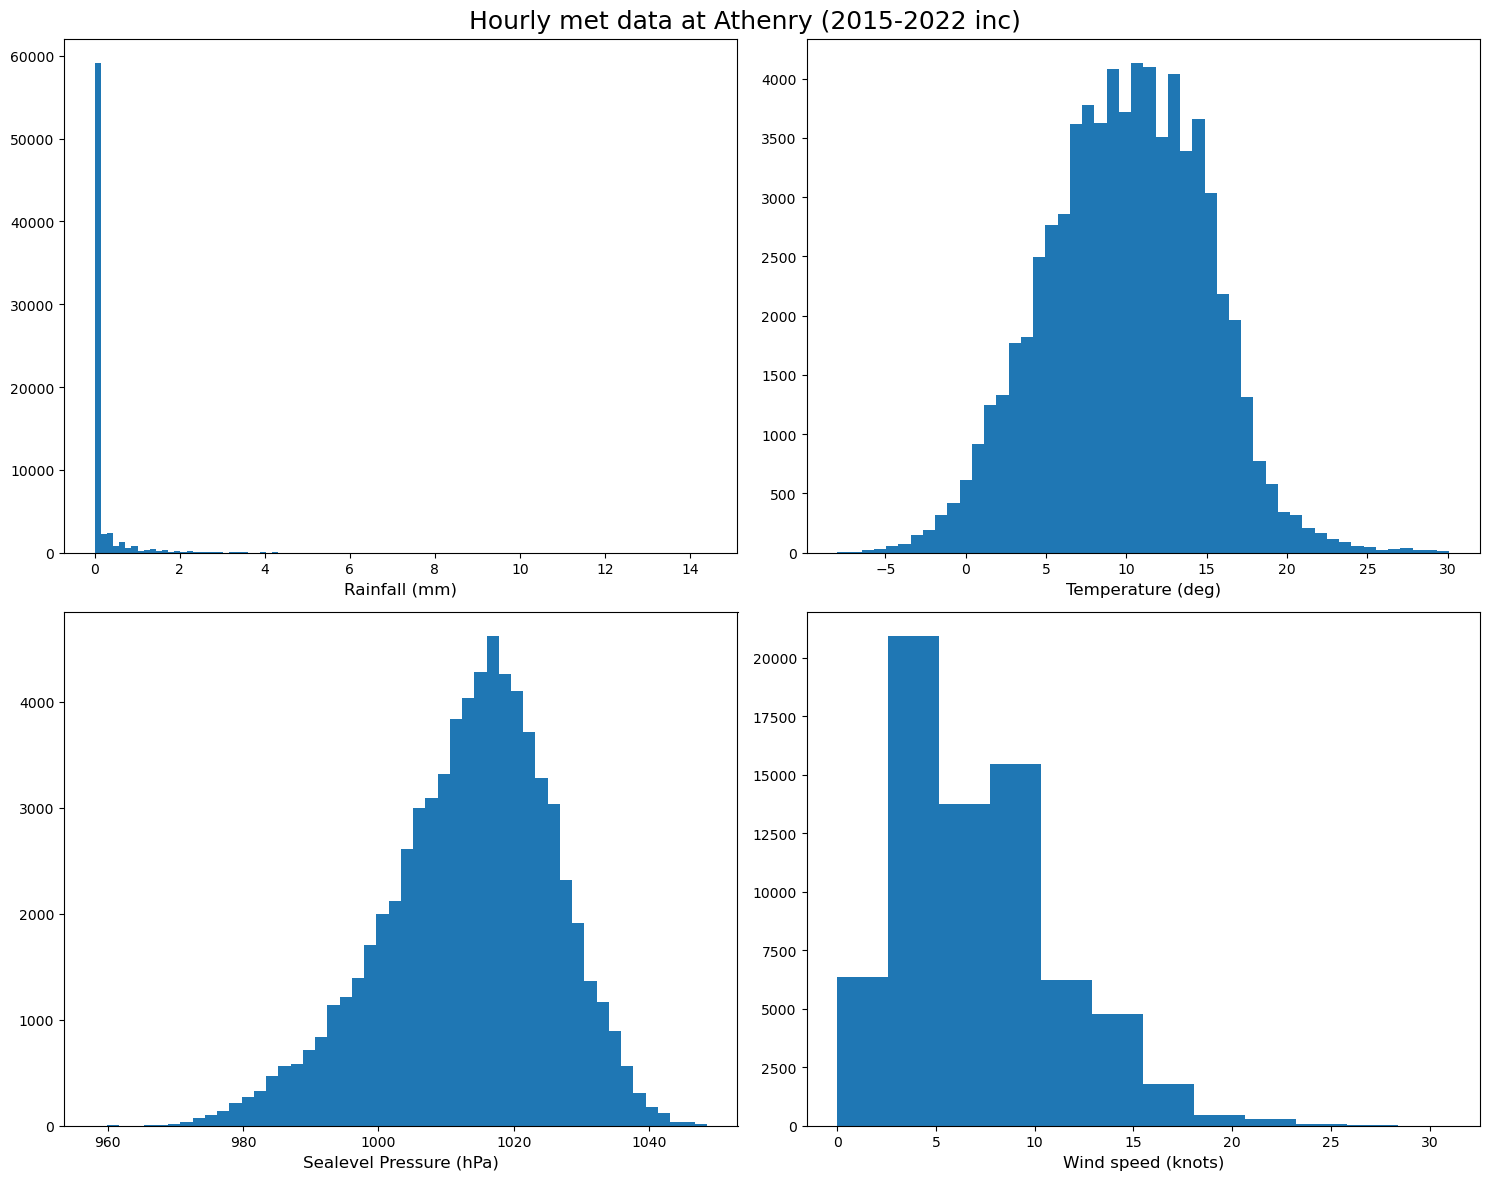

In [11]:
# Plots of the 8 year dataset for the 4 chosen variables
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Hourly met data at Athenry (2015-2022 inc)", fontsize=18)
axs[0,0].hist(data_df['rain'], bins=100)
axs[0,0].set_xlabel('Rainfall (mm)', fontsize=12)
axs[0,1].hist(data_df['temp'], bins=50)
axs[0,1].set_xlabel('Temperature (deg)', fontsize=12)
axs[1,0].hist(data_df['msl'], bins=50)
axs[1,0].set_xlabel('Sealevel Pressure (hPa)', fontsize=12)
axs[1,1].hist(data_df['wdsp'], bins=12)
axs[1,1].set_xlabel('Wind speed (knots)', fontsize=12)

plt.tight_layout()
plt.show()


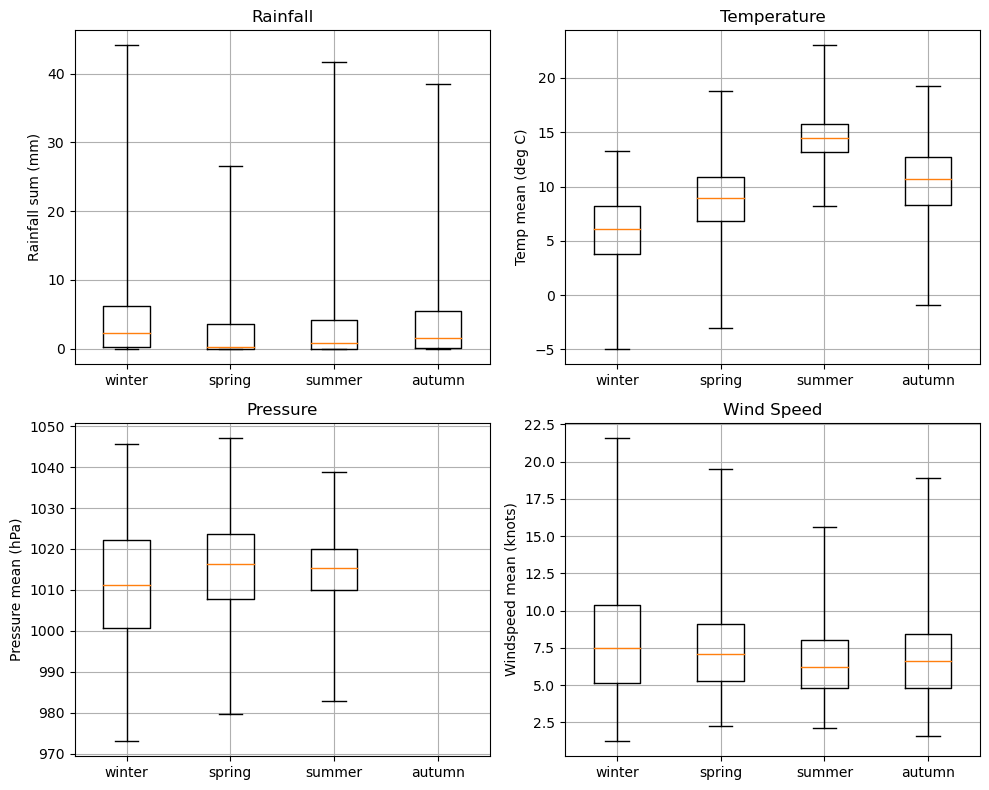

In [12]:
# Set up 1 fig with 4 boxplots
fig, axs = plt.subplots(2,2, figsize=(10, 8))
for i, var in enumerate(var_names):
    ax_list = [(0,0), (0,1), (1,0), (1,1)] 

    # create list of data to do a boxplot
    plot_data = [mydata_agg_i[var].loc[mydata_agg_i['season'] == 'winter'],
                mydata_agg_i[var].loc[mydata_agg_i['season'] == 'spring'],
                mydata_agg_i[var].loc[mydata_agg_i['season'] == 'summer'],
                mydata_agg_i[var].loc[mydata_agg_i['season'] == 'autumn']]

    # whis is arbitrarily high so that the whiskers represent min and max
    axs[ax_list[i]].boxplot(plot_data, whis=10000)   
    axs[ax_list[i]].set_ylabel(f'{var} {units_names[i]}')
    axs[ax_list[i]].set_xticklabels(class_names, fontsize=10)
    axs[ax_list[i]].set_title(plot_titles[i], fontsize=12)
    axs[ax_list[i]].grid(visible=True, which='both', axis='both')
fig.tight_layout() 


In [14]:
# troubleshooting pressure for autumn (HOLD)

plot_data = [mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'winter'],
                mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'spring'],
                mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'summer'],
                mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'autumn']]

print(mydata_agg_i['Pressure mean'].loc[mydata_agg_i['season'] == 'autumn'].describe())

count     726.000000
mean     1012.506204
std        11.956575
min       974.829167
25%      1003.811458
50%      1013.606250
75%      1021.504167
max      1040.820833
Name: Pressure mean, dtype: float64


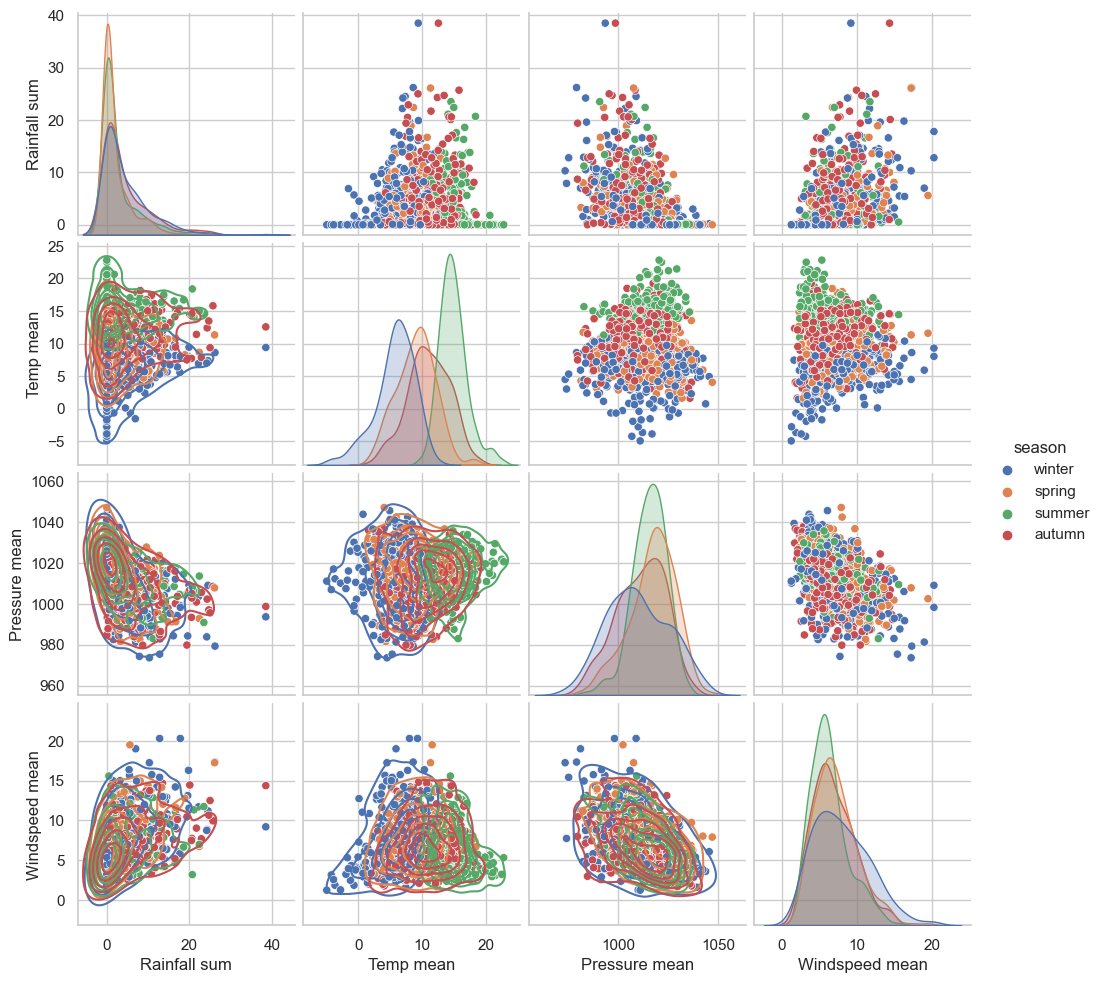

In [15]:
# Create a pairplot of the data for 3 years
sns.set_theme(style='whitegrid')
# take 3 years of data for the plot
data_3years = mydata_agg_i.loc[mydata_agg_i['datetime'].between('2020-01-01', '2022-12-31')]
g = sns.pairplot(data_3years, hue="season", diag_kind="kde")
g.map_lower(sns.kdeplot, levels=7, color=".2")
plt.show()

## Overall Variable Correlation <a id="Corr"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
In order to investigate correlation between the data variables, the Pearson correlation method in pandas is applied to the data (by season).

- Overall, there is no very strong correlation between any of the data variables investigated as part of this study. This was inferred above in the pairplot. Correlation values greater or less than 0.3 and -0.3 respectively are highlighted in the tables below.  

- The strongest correlations are between pressure and windspeed and pressure and rainfall. The correlation between pressure and windspeed ranges between -0.37 and -0.46 and ranges from from -0.49 to -0.42 between pressure and rainfall.   

- Winter shows the highest degree of correlation between the variables.

In [16]:
# Display the correlation table for the entire dataset
corr_styler_list = []
df_corr =  get_corr(mydata_agg_i.drop(columns = ["season", "datetime"]))    
df_styler = my_styler(df_corr, 2,  "Correlation - all data")
df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
corr_styler_list = [df_styler]

# Get correlation matrices for the 4 seasons and display
for i, item in enumerate(class_names):
    # Extract the data related to one season
    season_data = mydata_agg_i[mydata_agg_i["season"] == item].copy()
    # Strip the class column before passing to function
    season_data.drop(columns = ["season", "datetime"], inplace=True) 
    df_corr =  get_corr(season_data)      
    df_styler = my_styler(df_corr, 2, item + " Correlation")
    df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
    df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
    corr_styler_list.append(df_styler)
    
for item in corr_styler_list:
    display(item)



0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,0.02,-0.45,0.40
Temp mean,0.02,1.00,0.10,-0.02
Pressure mean,-0.45,0.10,1.00,-0.41
Windspeed mean,0.40,-0.02,-0.41,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,0.22,-0.45,0.46
Temp mean,0.22,1.00,-0.00,0.44
Pressure mean,-0.45,-0.00,1.00,-0.41
Windspeed mean,0.46,0.44,-0.41,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,-0.11,-0.49,0.44
Temp mean,-0.11,1.00,0.15,-0.07
Pressure mean,-0.49,0.15,1.00,-0.41
Windspeed mean,0.44,-0.07,-0.41,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,-0.05,-0.48,0.29
Temp mean,-0.05,1.00,0.13,-0.20
Pressure mean,-0.48,0.13,1.00,-0.46
Windspeed mean,0.29,-0.20,-0.46,1.00


,Rainfall sum,Temp mean,Pressure mean,Windspeed mean
Rainfall sum,1.00,0.17,-0.42,0.39
Temp mean,0.17,1.00,0.01,0.23
Pressure mean,-0.42,0.01,1.00,-0.37
Windspeed mean,0.39,0.23,-0.37,1.00


## Rainfall Analysis <a id="Rain"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
### Rainfall data analysis
- The rainfall is highly skewed towards values of zero. The data here may be seen as split into two regimes - the time or days when there is no rain and then those times or days when there is rain as is done here [4].
- It is useful to remove the 0 rainfall days by imposing a 1mm limit to determine a "rainy day" v "dry day". This approach is used here [4].
- Rainfall over a period of time can follow an exponential distribution [4] when the 0 rainfall periods are removed. The exponential distribution is shown below and appears to be a good fit to the "rainy day" data [6].  

The exponential distribution:

$$
f(x;\lambda) = 
\begin{cases} 
\lambda e^{-\lambda x} & \text{if } x \geq 0 \\
0 & \text{if } x < 0 
\end{cases}
$$

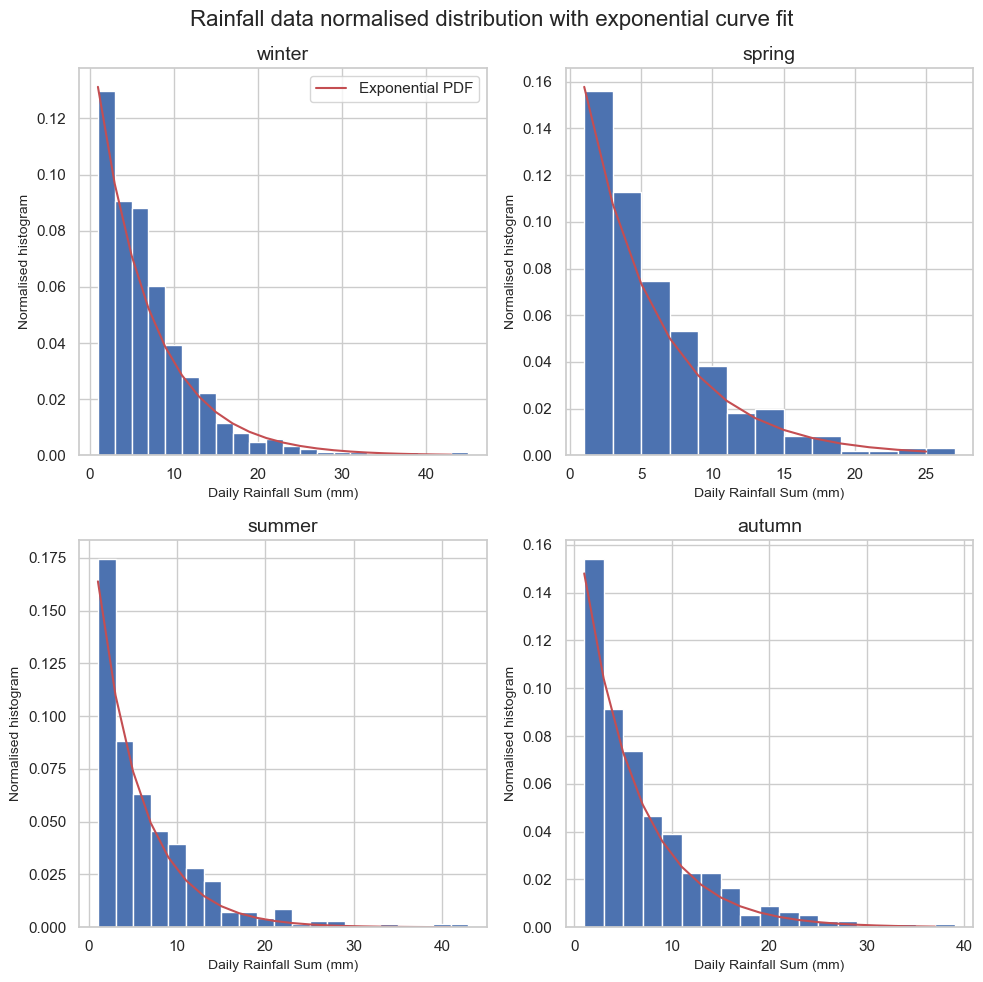

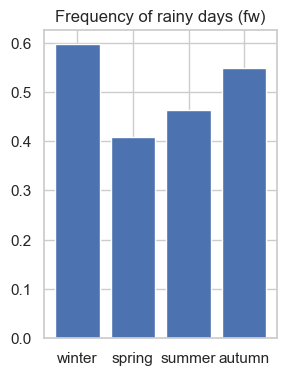

In [24]:
# Do some analysis on the daily aggregated rainfall data over 8 years.
rainfall_df = mydata_agg_i[['Rainfall sum', 'datetime', 'season']]
rainfall_df = rainfall_df.set_index('datetime')
max_rain = rainfall_df['Rainfall sum'].max()
min_rain = rainfall_df['Rainfall sum'].min()

fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Rainfall data normalised distribution with exponential curve fit', fontsize=16)

# Define empty lists to store the rainfall params and frequency from the curve fit for data synthesisation later
rainfall_exp_params_season = []
fw_seasonal = []
for i, season in enumerate(class_names):
  rainfall_df_season = pd.DataFrame()
  rainfall_df_season = rainfall_df[rainfall_df['season'] == season].drop(columns=['season'])
  # frequency of rainy days with criterion of >1mm rainfall in a day
  fw = (rainfall_df_season['Rainfall sum']>1).sum() / len(rainfall_df_season)
  fw_seasonal.append(fw)
  daily_rain_rainydays = rainfall_df_season[rainfall_df_season['Rainfall sum']>1]
  # defining the bin size
  bin_size = 2
  # find the min and max of the data
  daily_rain_rainydays_floor = math.floor(daily_rain_rainydays['Rainfall sum'].min())
  daily_rain_rainydays_ceiling = math.ceil(daily_rain_rainydays['Rainfall sum'].max())

  # generate a list of bins based on the above to fit the data
  bins = np.arange(daily_rain_rainydays_floor, daily_rain_rainydays_ceiling+bin_size, bin_size)
  ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  # returns the normalised data for the histogram (area under curve =1)

  n, bins_returned, _ = axs[ax_list[i]].hist(daily_rain_rainydays['Rainfall sum'], bins=bins, density=True)
  bin_start = np.array(bins[:-1])

  # Use curve_fit method as in: https://stackoverflow.com/questions/50448199/lognormal-curve-fit
  # PDF for the exponential distribution - so that curve fitting can be done
  def f_exp(bin_start, lamda_1):
    return lamda_1*np.exp(-1*lamda_1*bin_start)

  # returns the exponential distribution parameters for the data fit
  params, extras = curve_fit(f_exp, bin_start, n)

  # fit a exponential curve
  lamda_1 = params[0]
  pdf_expon = (lamda_1*np.exp(-1*lamda_1*bin_start))
  rainfall_exp_params_season.append(lamda_1)

  axs[ax_list[i]].plot(bin_start, pdf_expon, 'r', label='Exponential PDF')
  axs[ax_list[i]].set_xlabel(f'Daily Rainfall Sum (mm)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()
fig, ax = plt.subplots(1, figsize=(3, 4));
ax.bar(class_names, fw_seasonal);
ax.set_title("Frequency of rainy days (fw)");


## Pressure Analysis <a id="Pressure"></a> <span style="font-size: 8pt;"> [[TOC]](#toc)</span> 
The seasonal mean sea level pressure is plotted below and a log normal distribution is fitted to the data.

- From the preliminary analysis above, the distribution of pressure is skewed to the left.
- Trying a lognormal normal distribution seems to provide a reasonably accurate fit to the data. There is some underestimation at lower values. 


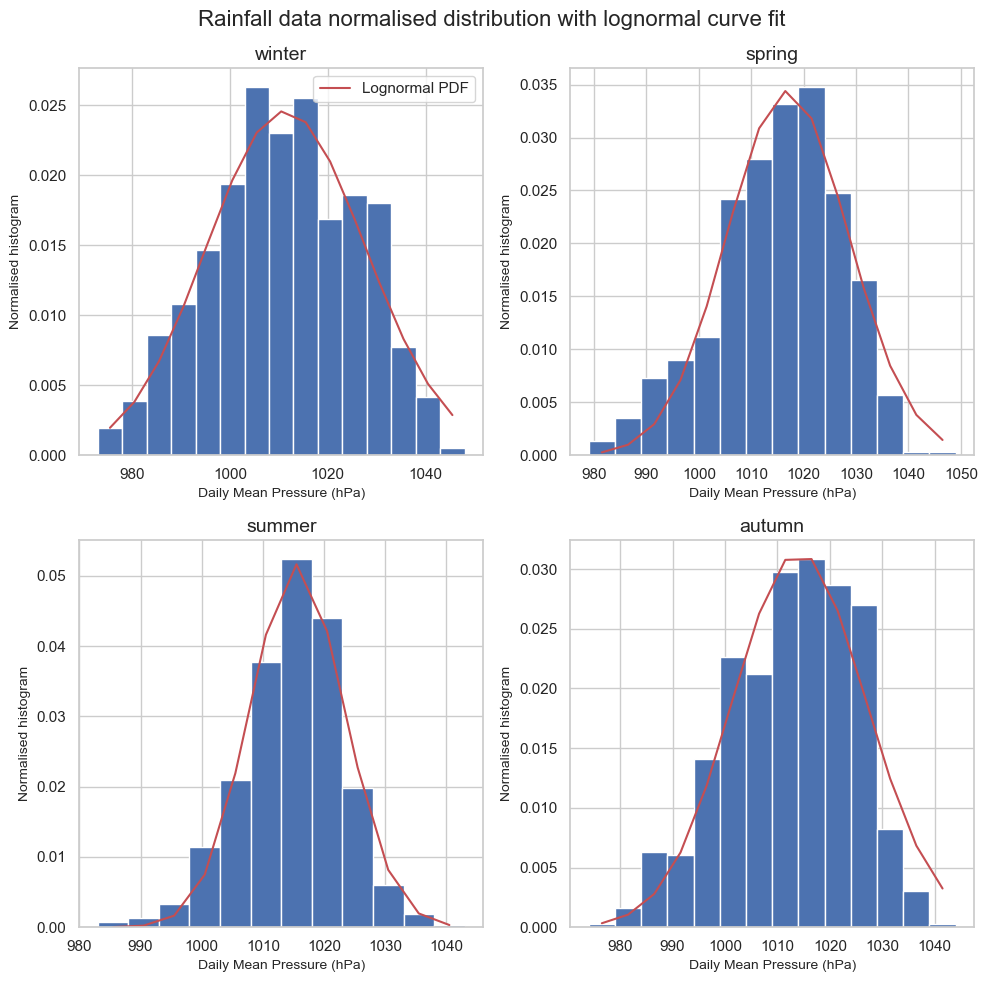

In [38]:
# Define empty lists to store the pressure params and frequency from the curve fit for data synthesisation later
pressure_params_season = []
pressure_df = mydata_agg_i[['Pressure mean', 'datetime', 'season']]
pressure_df = pressure_df.set_index('datetime')
# 
fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Rainfall data normalised distribution with lognormal curve fit', fontsize=16)
# Axis list for looping over axes below
ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  
for i, season in enumerate(class_names):
  pressure_df_season = pd.DataFrame()
  pressure_df_season = pressure_df[pressure_df['season'] == season].drop(columns=['season'])
  
  # defining the bin size
  bin_size = 5
  # find the min and max of the data
  data_floor = math.floor(pressure_df_season['Pressure mean'].min())
  data_ceiling = math.ceil(pressure_df_season['Pressure mean'].max())

  # Generate a list of bins based on the min and max above to fit the data
  bins = np.arange(data_floor, data_ceiling+bin_size, bin_size)
  # Returns the normalised data for the histogram (area under curve =1)
  n, bins_returned, _ = axs[ax_list[i]].hist(pressure_df_season['Pressure mean'], bins=bins, density=True)
  
  # Gets the mid-point of the bins
  bin_mid = mean_bins(bins_returned)

# https://en.wikipedia.org/wiki/Log-normal_distribution
# This could be moved into functions section 
  def f_lognormal(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)-mu)**2)/(2*sigma**2))

  # returns mu and sigma in params 
  params, extras = curve_fit(f_lognormal, bin_mid, n)
  mu_pressure = params[0]
  sigma_pressure = params[1]
  # store tuples to this list for use in the data synth later
  pressure_params_season.append((mu_pressure, sigma_pressure))
  # fit a lognormal curve
  pdf_lognormal = f_lognormal(bin_mid, mu_pressure, sigma_pressure)

  axs[ax_list[i]].plot(bin_mid, pdf_lognormal, 'r', label='Lognormal PDF')
  axs[ax_list[i]].set_xlabel(f'Daily Mean Pressure (hPa)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()

## Temperature Data Analysis
Qualitatively, the preliminary analysis of temperature distribution above shows a broadly normal distribution.  The normal distribution PDF is given below.
The synthesised data histogram (for a population of 365 days), shows reasonable quantitative match with the actual data when a random normal distribution is generated.


$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \big( \frac{x- \mu}{\sigma} \big)^2} $$

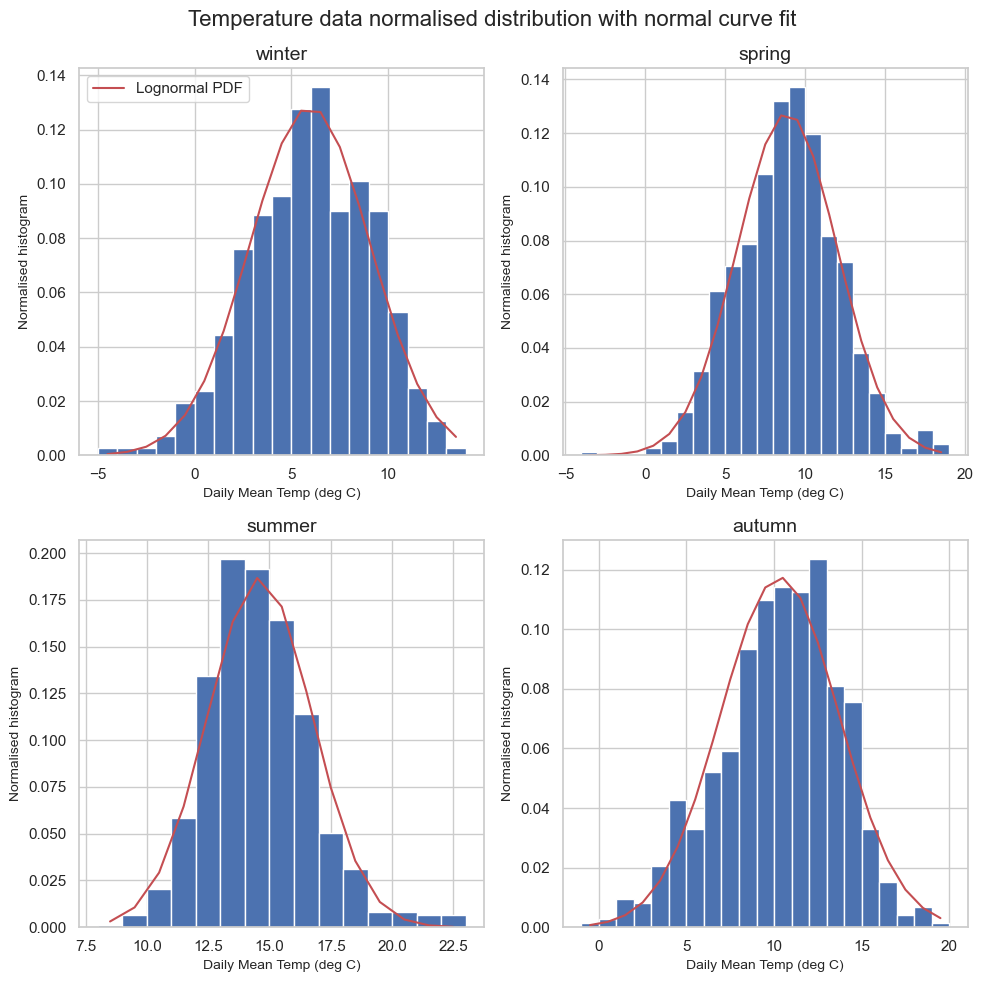

In [44]:
# Define empty lists to store the pressure params and frequency from the curve fit for data synthesisation later
temp_params_season = []
temp_df = mydata_agg_i[['Temp mean', 'datetime', 'season']]
temp_df = temp_df.set_index('datetime')
# 
fig, axs = plt.subplots(2,2, figsize=(10, 10));
fig.suptitle('Temperature data normalised distribution with normal curve fit', fontsize=16)
# Axis list for looping over axes below
ax_list = [(0,0), (0,1), (1,0), (1,1)] 
  
for i, season in enumerate(class_names):
  temp_df_season = pd.DataFrame()
  temp_df_season = temp_df[temp_df['season'] == season].drop(columns=['season'])
  
  # defining the bin size
  bin_size = 1
  # find the min and max of the data
  data_floor = math.floor(temp_df_season['Temp mean'].min())
  data_ceiling = math.ceil(temp_df_season['Temp mean'].max())

  # Generate a list of bins based on the min and max above to fit the data
  bins = np.arange(data_floor, data_ceiling+bin_size, bin_size)
  # Returns the normalised data for the histogram (area under curve =1)
  n, bins_returned, _ = axs[ax_list[i]].hist(temp_df_season['Temp mean'], bins=bins, density=True)
  
  # Gets the mid-point of the bins
  bin_mid = mean_bins(bins_returned)
  mu_temp = temp_df_season['Temp mean'].mean()
  sigma = temp_df_season['Temp mean'].std()
  param = norm.fit(temp_df_season['Temp mean'])
  pdf_fitted_norm = norm.pdf(bin_mid, loc=param[0], scale=param[1])
  pdf = norm.pdf(bins)
  
  # store tuples to this list for use in the data synth later
  temp_params_season.append((param[0], param[1]))
  # fit a normal curve
  axs[ax_list[i]].plot(bin_mid, pdf_fitted_norm, 'r', label='Normal PDF')
  axs[ax_list[i]].set_xlabel(f'Daily Mean Temp (deg C)', fontsize=10)
  axs[ax_list[i]].set_ylabel(f'Normalised histogram', fontsize=10)
  axs[ax_list[i]].set_title(season, fontsize=14)
  axs[ax_list[i]].grid(visible=True, which='both', axis='both')
axs[(0,0)].legend();
fig.tight_layout()



# Synthesising Relative Humidity Data

The daily mean relative humidity data is plotted below for the entire 8 year dataset. This dataset displays a left skew (the tail of the graph is to the left).
The log-normal distribution again appears to give a reasonable fit to the data as shown in the normalised pdf curvefit against the histogram of meteorological data.




In [ ]:
no_bins = 30
n, bins_returned, patches = plt.hist(mydata_agg['rhum mean'], bins=no_bins, density=True);
#rhum_syn = np.random.poisson(mydata_agg['rhum mean'].mean(), 2000)
#plt.hist(rhum_syn, bins=no_bins, density=True)

bins = mean_bins(bins_returned)
#bins = bins_returned

# returns mu and sigma in params 
params, extras = curve_fit(f_lognormal, bins, n)

mu_rhum = params[0]
sigma_rhum = params[1]
# fit a lognormal curve
pdf_lognormal = f_lognormal(bins, mu_rhum, sigma_rhum)
plt.plot(bins, pdf_lognormal, 'r')
#plt.show()

random_daily_rhum_1yr = np.random.default_rng().lognormal(mean=mu_rhum, sigma=sigma_rhum, size = len(mydata_agg))

#plt.hist(mydata_agg['rhum mean'], bins=no_bins);
#plt.hist(random_daily_rhum_1yr, bins=no_bins);

pop_size = 365
#https://stackoverflow.com/questions/71980083/specifiying-range-for-log-normal-distribution-in-python
# Want to exclude values over 100
#for sample in len(365):
#  random_daily_rhum_1yr = np.random.default_rng().lognormal(mean=mu_rhum, sigma=sigma_rhum, size = len(mydata_agg))



# https://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html
from scipy.stats import norm, rayleigh, lognorm, multivariate_normal, expon
param = norm.fit(mydata_agg['rhum mean'])
pdf_fitted = norm.pdf(bins, loc=param[0], scale=param[1])
pdf = norm.pdf(bins)
plt.plot(bins, pdf_fitted, 'b-', label="Normal fit")



param = rayleigh.fit(mydata_agg['rhum mean'])
pdf_fitted_rayleigh = rayleigh.pdf(bins, loc=param[0], scale=param[1])
pdf = rayleigh.pdf(bins)
plt.plot(bins, pdf_fitted_rayleigh, 'g-', label="Rayleigh fit")



param = lognorm.fit(mydata_agg['rhum mean'])

#mean, var, skew, kurt = lognorm.fit(mydata_agg['rhum mean'])
pdf_fitted_lognorm = lognorm.pdf(bins, param[0], param[1], param[2])
#pdf = lognorm.pdf(bins)
plt.plot(bins, pdf_fitted_lognorm, 'y-', label="Lognormal fit")


# not relevant
param = expon.fit(mydata_agg['rhum mean'])

#mean, var, skew, kurt = lognorm.fit(mydata_agg['rhum mean'])
pdf_fitted_expon = expon.pdf(bins, param[0])
#pdf = lognorm.pdf(bins)
plt.plot(bins, pdf_fitted_expon, 'y-', label="Lognormal fit")
plt.legend()
plt.show()




In [ ]:
n, bins_returned, patches = plt.hist(mydata_agg['wdsp max'], bins=15, density=True);

bins_mean = mean_bins(bins_returned)
bins = bins_returned[:-1]
param = norm.fit(mydata_agg['wdsp max'])
pdf_fitted = norm.pdf(bins, loc=param[0], scale=param[1])
pdf = norm.pdf(bins)
plt.plot(bins, pdf_fitted, 'r-', label="Normal fit")


param = lognorm.fit(mydata_agg['wdsp max'])

#mean, var, skew, kurt = lognorm.fit(mydata_agg['rhum mean'])
pdf_fitted_lognorm = lognorm.pdf(bins, param[0], param[1], param[2])
#pdf = lognorm.pdf(bins)
plt.plot(bins_mean, pdf_fitted_lognorm, 'y-', label="Lognormal fit")
plt.legend()
plt.show()

plt.scatter(mydata_agg_i['wdsp max'], mydata_agg_i['Msl mean']);
plt.show()

r = np.corrcoef(mydata_agg_i['wdsp max'], mydata_agg_i['Msl mean'])
print(r)

from scipy import stats

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
linearregres_result = stats.linregress(mydata_agg_i['Msl mean'], mydata_agg_i['wdsp max'], alternative='two-sided')
print(linearregres_result)


In [ ]:
# Rainfall synth

# set up a random generator for exponential distribution
# https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.exponential.html
# generate 1 year of daily rainfall totals - assuming that the frequency of rainy days calculated above
random_daily_rainfall_1yr = np.random.default_rng().exponential(1/lamda_1, int(365*fw))
plt.hist(random_daily_rainfall_1yr, bins=bin_fit, density=True)
plt.show()

no_rainfall_days = int(fw * 365)
daily_non_rainfall_1yr = np.array((365-no_rainfall_days)*[0])

year_rainfall_syn_data = np.concatenate((random_daily_rainfall_1yr, daily_non_rainfall_1yr))

np.random.shuffle(year_rainfall_syn_data)

plt.plot(year_rainfall_syn_data)
plt.plot(mydata_agg_i['Rainfall sum'][0:365])


In [ ]:
# Synthesise data for msl (pressure)
# https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.lognormal.html
# Generate 1 year of daily mean pressure data
random_daily_pressure_1yr = np.random.default_rng().lognormal(mean=mu_pressure, sigma=sigma_pressure, size = 365)

## Rainfall synth

- Taking the daily aggregated data, the frequency of rainy days, fw, is calculated by classifying a "rainy" day as one in which the total rainfall is >1mm.  
- From HOLD years of data, the frequency of rainy days is approximately 0.5, i.e., So 1 in 2 days has rainfall overall.
- It is possible to generate data for 1 year to synthesise daily rainfall totals by the following:
    -- generate some random data based on the exponential distribution parameters which describe the rainfall daily total distribution. The size of the random data is based on the frequency of rainy days, fw, multiplied by the total number of days of required data. 
- The number of dry days is found by subtracting rainy days from the total number of days and a value of 0 is assigned.
- The 2 arrays are joined together and then shuffled randomly.
- It would perhaps be more meaningful to find a distribution for each season and generate synthesised data on a season basis.
- The synthesised data when generated for a 1 year period does not accurately capture the probability of having higher values. It would perhaps be better to synthesise a larger set and then 


In [ ]:
# Getting the correlation coefficients between the daily mean pressure and the daily rainfall amount for the days that have >1mm rainfall.
plt.scatter(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1]);
res = stats.linregress(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1], alternative='two-sided')

plt.plot(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], res.intercept + res.slope*mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], 'r', label='fitted line')
plt.show()

r = np.corrcoef(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1])
print(r)
res = stats.linregress(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], np.log(mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1]), alternative='two-sided')
plt.scatter(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], np.log(mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1]));
plt.plot(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], res.intercept + res.slope*mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], 'r', label='fitted line')
plt.show()


In [ ]:
#Temp synth
mu = mydata_agg['Temp mean'].mean()
sigma = mydata_agg['Temp mean'].std()




temp_syn = np.random.normal(mu, sigma, size = 365)
plt.hist(temp_syn, bins=no_bins, density=True);
plt.show()
